# FORMAL

In [1]:
import matplotlib.pyplot as plt
import torch.nn as nn
import cv2
import numpy as np
from torchvision.utils import save_image
import torch

In [2]:
class Visualization_MTMK(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model.train().cuda()
        for alpha in self.model.alpha:
            alpha.requires_grad = True
        for X_train in self.model.X_train:
            X_train.requires_grad = True
        for kernel in self.model.kernel_list:
            kernel.kernel = kernel.kernel.cuda()

        # placeholder for the gradients
        self.gradients = None
        
    def forward(self, x, task):            
        # apply the remaining pooling
        x = x.cuda()
        x = self.model.high_dim_predict_nightly(x, task)
        return x.cpu()

In [3]:
def heatmap(image, label, task, no, trained_model, threshold):
    orignal_image = image.reshape(1, 28, 28)
    # image should be a 784 dimension tensor
    trained_model.zero_grad()
    model = Visualization_MTMK(trained_model)
    # model.eval()
    # get logit with regards to the label
    image = image.detach()
    image.requires_grad = True
    image.retain_grad()
    pred = model(image, task)
    
    pred.backward()
    gradients = image.grad
    gradients *= label.double()
    
    # RELU
    heatmap = torch.maximum(gradients, torch.tensor(0))

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    attention_map = heatmap.reshape(28, 28).detach().cpu().numpy()
    
    
    input_tensor = image.reshape(1, 28, 28).clone().cpu()
    # [0,1] to [0,255]，CHW2HWC, float to uint8
    input_tensor = input_tensor.mul_(255).permute(1, 2, 0).type(torch.uint8).numpy()
    # RGB2BRG
    input_tensor = cv2.cvtColor(input_tensor, cv2.COLOR_GRAY2BGR)
    
    attention_map = np.uint8(255 * attention_map)
    th = cv2.threshold(attention_map,threshold,255,cv2.THRESH_BINARY)[1]
    blur = cv2.GaussianBlur(th,(3,3), 11)
    heatmap_img = cv2.applyColorMap(blur, cv2.COLORMAP_JET)

    #merge map and frame
    superimposed_img = cv2.addWeighted(heatmap_img, 0.5, input_tensor, 0.5, 0)
    
    cv2.imwrite('./visualization/task_{}_no_{}_label_{}_map.png'.format(task, no, label.item()), superimposed_img)
    
    save_image(orignal_image.reshape(1, 28, 28), './visualization/task_{}_no_{}_label_{}_original.png'.format(task, no, label))
    plt.imsave('./visualization/task_{}_no_{}_label_{}_attention.png'.format(task, no, label.item()), attention_map)

In [4]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image 
import numpy as np
import cv2
from mt_model_gpu_grad import MtModel
from kernels_gpu_grad import *
model1 = torch.load('2023_04_08 04_33 FOLD 0 MTMK L1.pt')
model1 = model1.to('cuda')
# sample 10 images from 6 classes with label +1
np.random.seed(53)
images = []
for i in range(6):
    images_class = []
    indices = 10
    for k in tqdm(range(indices)):
        label = -1
        while label != 1:
            index = np.random.randint(80, 240, size=1)
            label = model1.Y_train[i][index.item()]
        if i == 5:
            threshold = 15
        else:
            threshold = 40

        heatmap(image=model1.X_train[i][index.item()], label=model1.Y_train[i][index.item()], task=i, no=index.item(), trained_model=model1, threshold=threshold)
        group = []
        img = matplotlib.image.imread('./visualization/task_{}_no_{}_label_1_original.png'.format(i, index.item()))
        group.append(img)
        # img = matplotlib.image.imread('./visualization/task_{}_no_{}_label_1_attention.png'.format(i, index.item()))
        # group.append(img)
        img = matplotlib.image.imread('./visualization/task_{}_no_{}_label_1_map.png'.format(i, index.item()))
        group.append(img)
        images_class.append(group)

    images.append(images_class)
    print('done for {}'.format(i))

100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


done for 0


100%|██████████| 10/10 [00:00<00:00, 35.68it/s]


done for 1


100%|██████████| 10/10 [00:00<00:00, 35.68it/s]


done for 2


100%|██████████| 10/10 [00:00<00:00, 34.57it/s]


done for 3


100%|██████████| 10/10 [00:00<00:00, 33.76it/s]


done for 4


100%|██████████| 10/10 [00:00<00:00, 36.20it/s]

done for 5


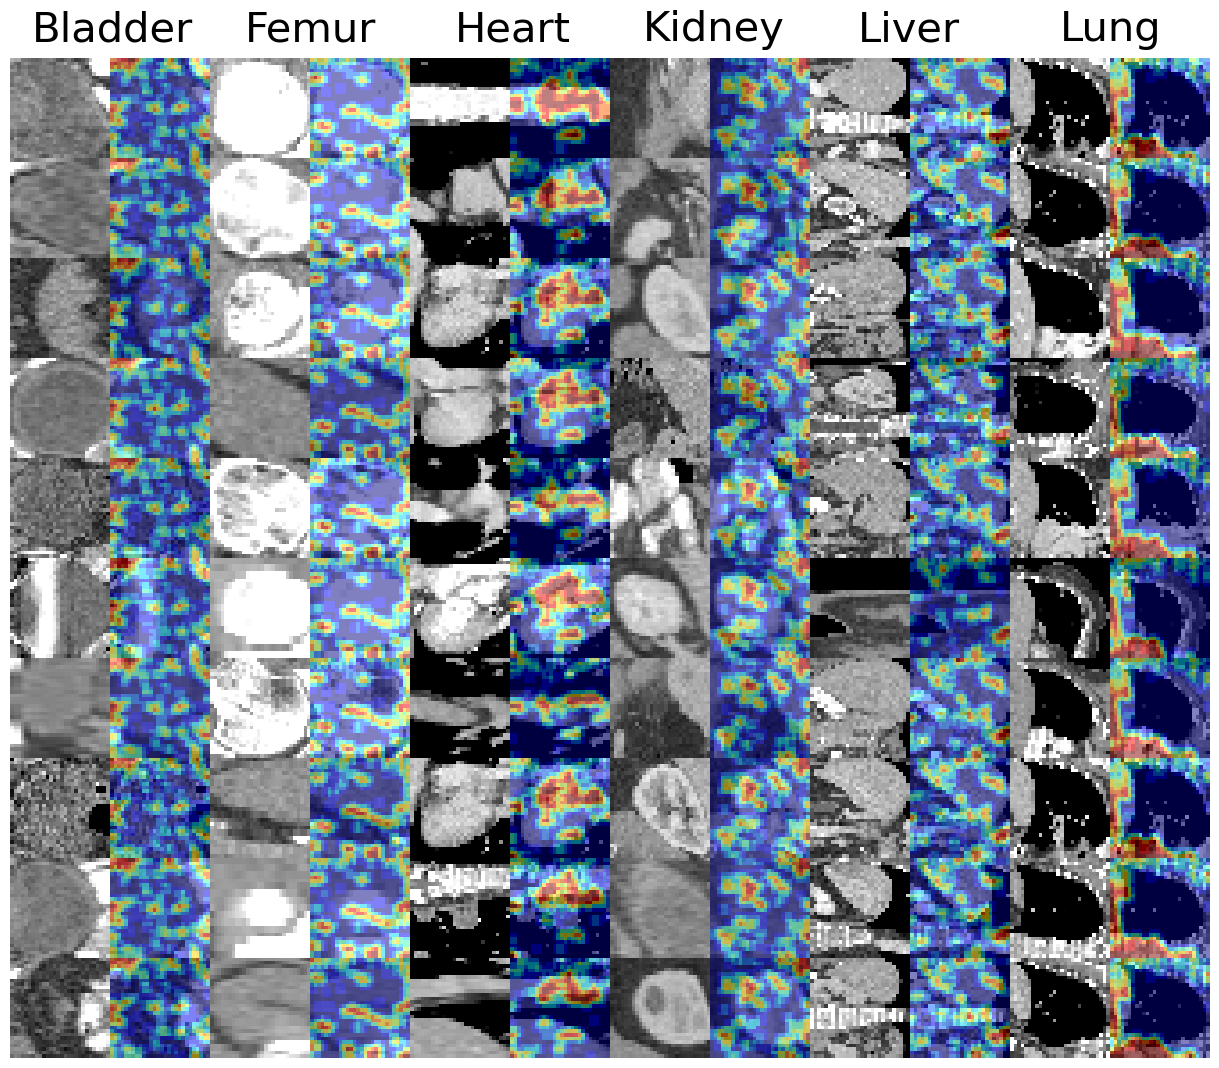

In [10]:
# Create a figure and axis objects
from matplotlib import gridspec
nrow = 10
ncol = len(images) * 2

fig, axes = plt.subplots(nrows=nrow, ncols=ncol,
                        gridspec_kw=dict(wspace=0.0, hspace=0.0,
                        top=1. - 0.5 / (nrow + 1), bottom=0.5 / (nrow + 1),
                        left=0.5 / (ncol + 1), right=1 - 0.5 / (ncol + 1)),
                        figsize=(ncol + 1, nrow + 1),)
# fig, axes = plt.subplots(gs)

# Plot the images
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if j < len(images) * 2:
            ax.imshow(images[j // 2][i][j%2])
        ax.axis('off')

fig.text(0.1175, 0.98, 'Bladder', ha='center', va='center', fontsize=30)
fig.text(0.27, 0.98, 'Femur', ha='center', va='center', fontsize=30)
fig.text(0.425, 0.98, 'Heart', ha='center', va='center', fontsize=30)
fig.text(0.58, 0.98, 'Kidney', ha='center', va='center', fontsize=30)
fig.text(0.73, 0.98, 'Liver', ha='center', va='center', fontsize=30)
fig.text(0.885, 0.98, 'Lung', ha='center', va='center', fontsize=30)

# Show the plot
plt.subplots_adjust(wspace=0, hspace=0)
fig.savefig('attentionmap.svg', format='svg')